## Module Load

In [314]:
import os
import torch
import pandas as pd
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
import wandb

# 요구사항1

## Dataset Class Definition

In [315]:
# Class for handling the Titanic dataset
class TitanicDataset(Dataset):
    def __init__(self, X, y):  # Initialize the dataset with input features and target labels
        self.X = torch.FloatTensor(X)  
        
        # Convert target labels to a long tensor for compatibility with PyTorch's cross-entropy loss,
        # which expects target labels in integer format.
        self.y = torch.LongTensor(y)  
    
    def __len__(self):  
        # Return the total number of samples.
        return len(self.X)
    
    def __getitem__(self, idx):  
        # Retrieve a single data sample and its corresponding label based on the index `idx`.
        # - `feature`: the input data sample at the specified index
        # - `target`: the target label at the specified index
        # The method returns a dictionary containing the input feature and target label for easy access.
        feature, target = self.X[idx], self.y[idx]
        return {'input': feature, 'target': target}  
    
    def __str__(self):  
        # Generate a string representation of the dataset, providing information about its size
        # and the shape of both the input data and target labels. Useful for debugging and data verification.
        str_info = "Data Size: {0}, Input Shape: {1}, Target Shape: {2}".format(
            len(self.X), self.X.shape, self.y.shape
        )
        return str_info


In [316]:
# Class for handling the Titanic test dataset
class TitanicTestDataset(Dataset):
    def __init__(self, X):  # Initialize the dataset with only input features (no labels in test set)
        self.X = torch.FloatTensor(X)  
    
    def __len__(self):  
        # Return the total number of samples in the dataset
        return len(self.X)
    
    def __getitem__(self, idx):  
        # Retrieve a single data sample based on the index `idx`. Since this is test data,
        # no target label is associated with the input sample.
        # - `feature`: the input data sample at the specified index.
        # The method returns a dictionary containing only the input feature.
        feature = self.X[idx]
        return {'input': feature}  
    
    def __str__(self):  
        # Generate a string representation of the dataset, providing information about its size
        str_info = "Data Size: {0}, Input Shape: {1}".format(
            len(self.X), self.X.shape
        )
        return str_info

## Data PreProcessing

In [317]:
def get_preprocessed_dataset_1(all_df):
    # Calculate average Fare for each Pclass and create a new DataFrame to store these values.
    Fare_mean = all_df[["Pclass", "Fare"]].groupby("Pclass").mean().reset_index()
    
    # Rename columns in Fare_mean DataFrame
    Fare_mean.columns = ["Pclass", "Fare_mean"]
    
    # Merge the calculated mean fares back to the original DataFrame based on Pclass 
    all_df = pd.merge(all_df, Fare_mean, on="Pclass", how="left")
    
    # For rows where the Fare value is missing, fill in the missing values with the calculated mean fare
    # from the corresponding Pclass.
    all_df.loc[(all_df["Fare"].isnull()), "Fare"] = all_df["Fare_mean"]
    
    return all_df

* get_preprocessed_dataset_1 : 타이타닉 데이터셋의 Fare(운임) 열에서 결측치가 존재할 경우,   
Pclass(객실 등급)별 운임 평균값을 사용해 해당 결측치를 채우기 위해 정의된 전처리 함수이다.

In [318]:
def get_preprocessed_dataset_2(all_df):
    '''
    Split the 'Name' column into separate columns for 'family_name', 'honorific', and 'name'.
    
    Args:
        all_df (pd.DataFrame): Input DataFrame containing the Titanic dataset.
    
    Returns:
        all_df (pd.DataFrame): DataFrame with new columns for 'family_name', 'honorific', and 'name'.
    '''
    
    # Split the 'Name' column into three parts using comma and period as delimiters, with a maximum of two splits.
    name_df = all_df["Name"].str.split("[,.]", n=2, expand=True)
    
    # Rename columns in the new DataFrame to clearly label each part of the name.
    name_df.columns = ["family_name", "honorific", "name"]
    
    # Remove any leading or trailing whitespace from each column in name_df for data consistency.
    name_df["family_name"] = name_df["family_name"].str.strip()
    name_df["honorific"] = name_df["honorific"].str.strip()
    name_df["name"] = name_df["name"].str.strip()
    
    # Concatenate the new columns from name_df with the original DataFrame, adding them as new columns.
    all_df = pd.concat([all_df, name_df], axis=1)
    
    return all_df


* get_preprocessed_dataset_2 : 타이타닉 데이터셋에서 승객의 Name 열을 family_name(성), honorific(경칭), name(이름)으로 분리하여 새로운 열로 추가하는 전처리 과정을 수행

In [319]:
def get_preprocessed_dataset_3(all_df):
    '''
    Fill missing 'Age' values based on the median 'Age' for each 'honorific'.
    
    Args:
        all_df (pd.DataFrame): Input DataFrame containing the Titanic dataset.
        
    Returns:
        all_df (pd.DataFrame): DataFrame with missing 'Age' values filled.
    '''
    
    # Calculate the median age for each honorific group, rounding to the nearest integer, reset the index for merging convenience.
    honorific_age_mean = all_df[["honorific", "Age"]].groupby("honorific").median().round().reset_index()
    
    # Rename columns in the honorific_age_mean DataFrame
    honorific_age_mean.columns = ["honorific", "honorific_age_mean"]
    
    # Merge the calculated median ages back to the original DataFrame based on honorific
    all_df = pd.merge(all_df, honorific_age_mean, on="honorific", how="left")
    
    # For rows where the Age value is missing, fill in the missing values with the calculated median age
    # from the corresponding honorific group.
    all_df.loc[(all_df["Age"].isnull()), "Age"] = all_df["honorific_age_mean"]
    
    # Remove the honorific_age_mean column after filling missing Age values to maintain data consistency.
    all_df = all_df.drop(["honorific_age_mean"], axis=1)
    
    return all_df


* get_preprocessed_dataset_3 : 타이타닉 데이터셋의 Age(나이) 열에서 결측치가 존재할 경우, honorific(경칭)별 나이의 중앙값을 사용해 해당 결측치를 채우는 전처리 작업을 수행

In [320]:
def get_preprocessed_dataset_4(all_df):
    '''
    Add 'family_num' and 'alone' columns, and remove unnecessary columns.
    
    Args:
        all_df (pd.DataFrame): Input DataFrame containing the Titanic dataset.
        
    Returns:
        all_df (pd.DataFrame): DataFrame with additional columns and unnecessary columns removed.
    '''
    
    # Create a new column 'family_num' to represent the number of family members each passenger is traveling with
    all_df["family_num"] = all_df["Parch"] + all_df["SibSp"]
    
    # Create a new column 'alone' to indicate whether a passenger is traveling alone.
    # If 'family_num' is 0, assign 1 to 'alone', otherwise fill with 0.
    all_df.loc[all_df["family_num"] == 0, "alone"] = 1
    all_df["alone"].fillna(0, inplace=True)
    
    # Drop columns that are deemed unnecessary for the learning process:
    # - 'PassengerId': Unique identifier with no predictive value.
    # - 'Name', 'family_name', 'name': Redundant after extracting 'honorific'.
    # - 'Ticket': Contains random alphanumeric values with limited predictive power.
    # - 'Cabin': Lacks sufficient data (many missing values) for reliable analysis.
    all_df = all_df.drop(["PassengerId", "Name", "family_name", "name", "Ticket", "Cabin"], axis=1)
    
    return all_df


* get_preprocessed_dataset_4 : 타이타닉 데이터셋에서 승객의 가족 구성 정보를 나타내는 family_num과 alone 열을 새롭게 추가하여 데이터의 특성을 확장하는 전처리 과정을 수행

In [321]:
def get_preprocessed_dataset_5(all_df):
    '''
    Reduce the values in the 'honorific' column and fill missing 'Embarked' values.
    
    Args:
        all_df (pd.DataFrame): Input DataFrame containing the Titanic dataset.
        
    Returns:
        all_df (pd.DataFrame): DataFrame with reduced 'honorific' values and filled 'Embarked' values.
    ''' 

    # Simplify the 'honorific' column by grouping less common titles into a single category 'other'.
    # Only retain major honorifics: 'Mr', 'Miss', 'Mrs', and 'Master'.
    all_df.loc[
        ~(
            (all_df["honorific"] == "Mr") |
            (all_df["honorific"] == "Miss") |
            (all_df["honorific"] == "Mrs") |
            (all_df["honorific"] == "Master")
        ),
        "honorific"
    ] = "other"
    
    # Fill missing values in the 'Embarked' column with the label 'missing' to represent unknown embarkation points.
    all_df["Embarked"].fillna("missing", inplace=True)

    return all_df


* get_preprocessed_dataset_5 : 타이타닉 데이터셋에서 honorific(경칭) 열에 포함된 값의 범위를 줄여 더 일반화된 카테고리로 묶고,   
Embarked(탑승지) 열의 결측치를 채우는 전처리 작업을 수행

In [322]:
def get_preprocessed_dataset_6(all_df):
  '''
  Encode categorical variables using LabelEncoder.
  
  Args:
    all_df (pd.DataFrame): Input DataFrame.
    
  Returns:
    all_df (pd.DataFrame): DataFrame with categorical variables encoded as numerical values.
  '''
  
  category_features = all_df.columns[all_df.dtypes == "object"]
  
  for category_feature in category_features:
      le = LabelEncoder()
      if all_df[category_feature].dtypes == "object":
        le = le.fit(all_df[category_feature])
        all_df[category_feature] = le.transform(all_df[category_feature])

  return all_df

* get_preprocessed_dataset_6 : LabelEncoder를 사용하여 범주형 변수를 수치형으로 변환하는 전처리 작업을 수행

### Data Loading
This code begins by loading the training and test datasets from CSV files, combining them into a single DataFrame. This approach allows for consistent preprocessing on both sets.

### Data Preprocessing
The combined dataset undergoes multiple preprocessing steps, which include:
1. Filling missing values (e.g., `Fare` and `Age` based on specific criteria),
2. Generating new features such as `family_num` and `alone` for enhanced context,
3. Encoding categorical variables into numerical representations for model compatibility.

Each step is executed through a series of preprocessing functions (`get_preprocessed_dataset_1` through `get_preprocessed_dataset_6`), allowing for modular data preparation.

### Data Splitting (Train/Validation/Test)
After preprocessing, the dataset is split into training, validation, and test sets:
- The training data is further split, with 80% for training and 20% for validation.
- The test set is set aside as a separate dataset for model evaluation.

### Output
The function returns three processed datasets: `train_dataset`, `validation_dataset`, and `test_dataset`, which are ready to be used for training and evaluation purposes.


In [323]:
def get_preprocessed_dataset():
    # CURRENT_FILE_PATH = os.path.dirname(os.path.abspath(__file__))
    CURRENT_FILE_PATH = os.getcwd()

    train_data_path = os.path.join(CURRENT_FILE_PATH, "train.csv")
    test_data_path = os.path.join(CURRENT_FILE_PATH, "test.csv")

    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(test_data_path)

    all_df = pd.concat([train_df, test_df], sort=False)

    all_df = get_preprocessed_dataset_1(all_df)

    all_df = get_preprocessed_dataset_2(all_df)

    all_df = get_preprocessed_dataset_3(all_df)

    all_df = get_preprocessed_dataset_4(all_df)

    all_df = get_preprocessed_dataset_5(all_df)

    all_df = get_preprocessed_dataset_6(all_df)

    train_X = all_df[~all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)
    train_y = train_df["Survived"]
    test_X = all_df[all_df["Survived"].isnull()].drop("Survived", axis=1).reset_index(drop=True)

    dataset = TitanicDataset(train_X.values, train_y.values)
    #print(dataset)
    train_dataset, validation_dataset = random_split(dataset, [0.8, 0.2])
    test_dataset = TitanicTestDataset(test_X.values)
    #print(test_dataset)

    return train_dataset, validation_dataset, test_dataset

# 요구사항2

### Custom Activation Function Selector
Defines a custom `ActivationFunc` class that selects an activation function based on name or index. This flexibility allows for easy switching between activation functions when building neural networks.

### Custom Neural Network Model
Defines `MyModel`, a neural network model class that incorporates two hidden layers, each with customizable activation functions. This model uses the `ActivationFunc` class to select and apply activation functions such as Leaky ReLU in the hidden layers.

### Model and Optimizer Initialization
The function `get_model_and_optimizer` creates an instance of the `MyModel` class and sets up an optimizer (SGD) with a learning rate of 0.01. This function returns both the model and the optimizer, ready for training.


In [324]:
# Custom neural network model with activation function selector
class ActivationFunc(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Define a dictionary of activation functions
        self.activate_dir_ = {
            'ReLU': nn.ReLU,
            'LeakyReLU': nn.LeakyReLU,
            'Sigmoid': nn.Sigmoid,
            'Tanh': nn.Tanh
        }
        
        # Store activation functions as a list for indexed selection
        self.activate_list_ = list(self.activate_dir_.values())
    
    # Return the specified activation function by name or index, defaulting to ReLU
    def activation_test(self, name=None, idx=None):
        if name is not None:
            return self.activate_dir_[name]()
        elif idx is not None:
            return self.activate_list_[idx]()

# Define the custom neural network model
class MyModel(nn.Module):
    def __init__(self, n_input, n_output):  # Initialize with input and output sizes
        super().__init__()  # Initialize the base class
        actFunc_ = ActivationFunc()  # Instantiate activation function selector

        # Define the model structure (two hidden layers included)
        self.model = nn.Sequential(
            nn.Linear(n_input, 30),  # Input layer to first hidden layer
            actFunc_.activation_test(name="LeakyReLU"),  # First hidden layer activation
            nn.Linear(30, 30),  # First hidden layer to second hidden layer
            actFunc_.activation_test(name="LeakyReLU"),  # Second hidden layer activation
            nn.Linear(30, n_output)  # Second hidden layer to output layer
        )
    
    # Define forward pass
    def forward(self, x):
        return self.model(x)  # Perform forward propagation through the model

# Function to get the model and optimizer
def get_model_and_optimizer(input_size, output_size):
    model = MyModel(input_size, output_size)  # Create an instance of the custom model
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # Define optimizer with learning rate 0.01
    return model, optimizer  # Return model and optimizer


### Training Loop
Defines the `training_loop` function, which iteratively trains the model over a set number of epochs, calculates training and validation loss, and logs metrics.    
The function also periodically prints progress to monitor training performance.


In [325]:
# Training loop function
def training_loop(model, optimizer, train_data_loader, validation_data_loader):
    n_epochs = 700  # Number of epochs for training
    loss_fn = nn.CrossEntropyLoss()  # Define loss function as cross-entropy loss
    next_print_epoch = 100  # Interval for printing progress

    for epoch in range(1, n_epochs + 1):
        model.train()  # Set model to training mode
        loss_train = 0.0  # Initialize training loss
        correct_train = 0  # Initialize count of correct predictions in training
        total_train = 0  # Initialize total sample count in training
        
        # Iterate over training batches
        for batch in train_data_loader:
            inputs, targets = batch['input'], batch['target']  # Get input and target data
            outputs = model(inputs)  # Compute model predictions
            loss = loss_fn(outputs, targets)  # Compute loss
            loss_train += loss.item()  # Accumulate training loss

            optimizer.zero_grad()  # Clear gradients
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update weights using optimizer

            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct_train += (predicted == targets).sum().item()  # Count correct predictions
            total_train += targets.size(0)  # Count total samples

        # Calculate validation loss and accuracy
        loss_validation = 0.0  # Initialize validation loss
        correct_val = 0  # Initialize count of correct predictions in validation
        total_val = 0  # Initialize total sample count in validation
        model.eval()  # Set model to evaluation mode
        
        with torch.no_grad():  # Disable gradient calculations
            for batch in validation_data_loader:  # Iterate over validation batches
                inputs, targets = batch['input'], batch['target']  # Get input and target data
                outputs = model(inputs)  # Compute model predictions
                loss = loss_fn(outputs, targets)  # Compute validation loss
                loss_validation += loss.item()  # Accumulate validation loss

                _, predicted = torch.max(outputs, 1)  # Get predicted class
                correct_val += (predicted == targets).sum().item()  # Count correct predictions
                total_val += targets.size(0)  # Count total samples

        # Calculate training and validation accuracy
        train_accuracy = correct_train / total_train
        val_accuracy = correct_val / total_val

        # Log epoch metrics to Wandb
        wandb.log({
            "Epoch": epoch,
            "Training loss": loss_train / len(train_data_loader),
            "Validation loss": loss_validation / len(validation_data_loader)
        })

        # Print metrics at specified intervals
        if epoch >= next_print_epoch:
            print(
                f"Epoch {epoch}, "
                f"Training loss {loss_train / len(train_data_loader):.4f}, "
                f"Validation loss {loss_validation / len(validation_data_loader):.4f}"
            )
            next_print_epoch += 100


# 요구사항3

### Test Function
Defines the `test_model` function, which evaluates the model on the test dataset, calculates accuracy, and saves predictions to a CSV file.    
This function runs in evaluation mode, logging results and storing predictions for further analysis.


In [326]:
# Test function
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    print("[TEST]")
    correct_test = 0  # Initialize count of correct predictions
    total_test = 0  # Initialize total sample count
    results = []  # List to store prediction results
    
    # Disable gradient calculations for testing
    with torch.no_grad():
        for batch in test_loader:
            inputs = batch['input']  # Retrieve input data
            outputs = model(inputs)  # Compute model outputs
            predictions = torch.argmax(outputs, dim=1)  # Get predicted classes
            
            # Print and store prediction results (index starts from 892)
            for idx, prediction in enumerate(predictions, start=892):
                print(idx, prediction.item())
                results.append({'PassengerId': idx, 'Survived': prediction.item()})
            
            # Placeholder evaluation: Count predictions assumed to be class 1
            correct_test += (predictions == 1).sum().item()  # Increment correct count
            total_test += predictions.size(0)  # Increment total count
    
    # Calculate and print test accuracy
    test_accuracy = correct_test / total_test
    print(f"Test accuracy: {test_accuracy:.4f}")

    # Display current working directory
    current_directory = os.getcwd()
    print(f"Current working directory: {current_directory}")

    # Save results to a CSV file in the current directory
    results_df = pd.DataFrame(results)
    file_path = os.path.join(current_directory, 'submission.csv')
    results_df.to_csv(file_path, index=False)
    print(f"Test results saved to {file_path}")


* ReLU(epoch 700)
training loss: 0.41133
validation loss: 0.55878
* ReLU(epoch 1000)
training loss: 0.46734
validation loss: 0.4957
* LeakyReLU(epoch 500)
training loss: 0.47058
validation loss: 0.44463
* LeakyReLU(epoch 600)
training loss: 0.43112
validation loss: 0.49409
* LeakyReLU(epoch 700)
training loss: 0.42969
validation loss: 0.42491
* LeakyReLU(epoch 800)
training loss: 0.43272
validation loss: 0.5212
* Sigmoid(epoch 700)
training loss: 0.5947
validation loss: 0.57474
* Tanh(epoch 700)
training loss: 0.44836
validation loss: 0.47141

위 결과를 기반으로 Leaky ReLU 활성화 함수가 가장 우수한 성능을 나타냈으며, 특히 epoch 700에서 가장 낮은 validation loss를 기록했습니다. 이를 통해 submission.csv 파일을 생성할 최적의 시점을 결정하기 위해, Leaky ReLU를 사용하여 다양한 epoch 수에 걸쳐 검증을 수행했습니다.

훈련 과정에서 Leaky ReLU의 epoch 500에서 validation loss가 0.44463으로 처음 안정되기 시작했으나, 추가적인 epoch (epoch 600~epoch 700) 동안 loss는 점진적으로 감소하였고 epoch 700에서 validation loss 0.42491로 최저치를 기록했습니다. 그러나 epoch 800에서 validation loss가 다시 증가하는 경향을 보임에 따라, epoch 700에서의 모델 상태가 최적의 성능을 보였다고 결론지었습니다.

이를 토대로, epoch 700에서의 모델 파라미터를 활용하여 최종 테스트를 수행하고, 최적화된 성능을 기반으로 submission.csv 파일을 구성하였습니다.

# 요구사항4

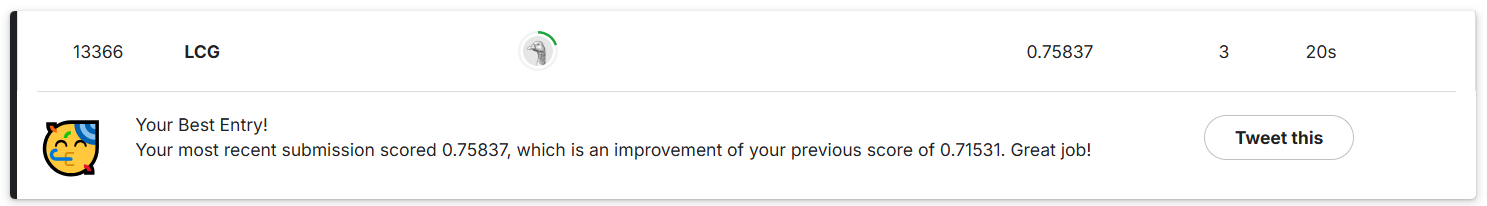

### Main Training and Evaluation Workflow
Sets up and configures the training environment, initializes the model and optimizer, and executes the training and evaluation processes.    
This function also leverages Wandb for experiment tracking, logs metrics, and saves the test results.


In [327]:
# Main function
if __name__ == "__main__":
    # Initialize Wandb settings
    current_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')  # Convert current time to string

    # Define configuration parameters
    config = {
        'epochs': 1000,  # Total training epochs
        'batch_size': 16,  # Batch size
        'learning_rate': 1e-3,  # Learning rate
    }

    # Initialize Wandb for experiment tracking
    wandb.init(
        mode="online",  # Set to online mode (enable Wandb logging)
        project="Titanic_Assign",  # Project name
        notes="Titanic dataset training with wandb",  # Experiment description
        tags=["titanic", "classification"],  # Set tags
        name=current_time_str,  # Set experiment name using current time
        config=config  # Pass configuration settings
    )

    # Load and split dataset
    train_dataset, validation_dataset, test_dataset = get_preprocessed_dataset()  # Get preprocessed datasets
    train_data_loader = DataLoader(dataset=train_dataset, batch_size=wandb.config.batch_size, shuffle=True)  # Training data loader
    validation_data_loader = DataLoader(dataset=validation_dataset, batch_size=len(validation_dataset))  # Validation data loader
    test_data_loader = DataLoader(dataset=test_dataset, batch_size=len(test_dataset))  # Test data loader
    
    # Define model and optimizer
    input_size = train_dataset[0]['input'].shape[0]  # Number of input features
    output_size = 2  # Number of output classes (survival: 0 or 1)
    model = MyModel(input_size, output_size)  # Create model instance
    optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate)  # Define optimizer (SGD)

    # Execute training loop
    training_loop(model, optimizer, train_data_loader, validation_data_loader)

    # Evaluate model on test dataset
    test_model(model, test_data_loader)
    
    wandb.finish()  # End Wandb session


C:\Users\User\AppData\Local\Temp\ipykernel_23476\96341194.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  all_df["alone"].fillna(0, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_23476\2552623324.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

Epoch 100, Training loss 0.5687, Validation loss 0.5850
Epoch 200, Training loss 0.5474, Validation loss 0.5661
Epoch 300, Training loss 0.5351, Validation loss 0.5625
Epoch 400, Training loss 0.4951, Validation loss 0.5536
Epoch 500, Training loss 0.4797, Validation loss 0.4822
Epoch 600, Training loss 0.4510, Validation loss 0.4604
Epoch 700, Training loss 0.4512, Validation loss 0.4456
[TEST]
892 0
893 0
894 0
895 0
896 1
897 0
898 1
899 0
900 1
901 0
902 0
903 0
904 1
905 0
906 1
907 1
908 0
909 0
910 1
911 0
912 0
913 0
914 1
915 1
916 1
917 0
918 1
919 0
920 0
921 0
922 0
923 0
924 1
925 1
926 1
927 0
928 1
929 1
930 0
931 1
932 0
933 1
934 0
935 1
936 1
937 0
938 0
939 0
940 1
941 1
942 1
943 0
944 1
945 1
946 0
947 0
948 0
949 0
950 0
951 1
952 0
953 0
954 0
955 1
956 1
957 1
958 1
959 0
960 0
961 1
962 1
963 0
964 1
965 0
966 1
967 0
968 0
969 1
970 0
971 1
972 0
973 0
974 0
975 0
976 0
977 0
978 1
979 1
980 1
981 1
982 1
983 0
984 1
985 0
986 0
987 0
988 1
989 0
990 1
991 0
9

Epoch,▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█████
Training loss,████▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▃▃▃▄▃▃▄▃▃▃▃▂▃▂▂▁▂▁
Validation loss,▇█▆▇▆▆▇▆▇▇▅▆▆▅▆▆▅▄▃▄▃▂▂▃▃▄▃▁▄▂▁▂▂▁▇▂▂▆▂▂
Epoch,700
Training loss,0.45123
Validation loss,0.44562


# 숙제후기

## Data Preprocessing and Feature Engineering
* 데이터 전처리 단계에서는 결측값 처리, 피처 생성, 범주형 변수 인코딩을 통해 모델 학습을 위한 데이터 품질을 개선했습니다.    
특히, 운임(Fare)과 나이(Age) 결측치를 채우기 위해 객실 등급별 평균 운임이나 경칭(honorific)별 중앙값 나이를 사용하는 등   
도메인 지식에 기반한 데이터 분석이 중요하다는 점을 확인했습니다. 이로써 피처 엔지니어링이 모델의 성능에 미치는 영향을 체험할 수 있었으며,    
데이터 전처리가 모델 학습의 필수 단계라는 것을 깊이 이해하게 되었습니다.

## Custom Neural Network Design and Activation Function Testing
* ActivationFunc 클래스와 같은 모듈화된 활성화 함수 선택기를 설계하여, 모델 설계 시    
다양한 활성화 함수(ReLU, Leaky ReLU, Sigmoid, Tanh)를 쉽게 실험할 수 있는 환경을 구성했습니다.    
각 활성화 함수에 따른 모델의 학습 성능을 비교함으로써, 신경망에서 활성화 함수가 손실 감소와 일반화 성능에 얼마나 큰 영향을 미치는지 파악할 수 있었습니다.    
특히, ReLU와 Leaky ReLU가 더 좋은 성능을 보였으며, 그중에서도 Leaky ReLU가 epoch 700에서 가장 낮은 validation loss를 기록하며 최적의 성능을 보여 이를 선택하게 되었습니다.     
이러한 실험을 통해 활성화 함수가 학습의 수렴성과 과적합 방지에 중요한 요소임을 확인했습니다.

## Optimization and Training Loop Design
* 이번 과제에서는 SGD(확률적 경사 하강법)를 사용한 최적화와 교차 엔트로피 손실을 활용하여 모델의 학습을 진행했습니다.    
학습 루프(training_loop)를 설계하며 학습 및 검증 데이터에서의 성능을 주기적으로 모니터링하여, 학습과정 중의 손실값 감소 추세와 과적합 여부를 체크했습니다.     
또한, 최적의 성능을 기록한 epoch 700에서의 모델 파라미터를 사용하여 최종 예측을 수행했습니다.     
이를 통해, 하이퍼파라미터 튜닝과 조기 종료 기법의 중요성을 다시금 인식하게 되었으며, 컴퓨터 과학적 사고로서 학습 과정 중 모델 성능의 변화를 분석하는 능력을 강화할 수   있었습니다.

## Experiment Management and Logging (Using Wandb)
* 이번 과제에서 Wandb를 활용하여 모델의 실험을 관리하고, 각 에포크에서의 학습/검증 손실, 정확도를 추적했습니다.     
실험 로그를 통해 각 활성화 함수와 학습 파라미터 변화에 따른 성능 차이를 비교하고 시각화함으로써,     
모델 성능에 대한 분석과 이해를 돕는 실험 관리의 중요성을 경험할 수 있었습니다.      
이를 통해 ML 파이프라인에서 실험 추적과 관리가 실험의 재현성 확보와 모델 개선에 필수적이라는 것을 체감하게 되었습니다.

## Testing and Final Model Evaluation
* 테스트 함수에서 예측 결과를 CSV 파일로 저장하고 최종 정확도를 측정하여 모델의 성능을 검증했습니다.   
특히, 모델 선택을 위해 각 활성화 함수 및 epoch별 성능을 검토한 후 최적의 파라미터를 선정하는 과정에서 모델 평가의 엄밀성과 다양한 성능 지표의 중요성을 깨닫게 되었습니다.   
모델이 훈련 및 검증 데이터에 대한 성능뿐만 아니라, 테스트 데이터에서도 일반화 성능을 유지할 수 있는지 확인하는 것이 모델 개발의 중요한 단계라는 것을 실감했습니다.

## Conclusion
* 이번 과제는 단순한 모델 구현을 넘어 데이터 전처리, 활성화 함수 실험, 최적화, 실험 관리, 그리고 평가까지의 전 과정을 포함한 종합적인 딥러닝 과제였습니다.   
이를 통해 컴퓨터 과학 및 머신러닝의 기초적인 원리를 다각적으로 체험하고, 실제 모델을 개발하는 과정에서 겪는 여러 도전 과제들을 다루며 실질적인 문제 해결 능력을 키울 수 있었습니다.